## Enunciado

> Se pretende construir una planta desalinizadora de agua, con el fin de proporcionar agua potable a ciertas poblaciones en las que escasea. Usted, como encargado de la planificación de la ejecución de este proyecto, decide que la descomposición en tareas y sus precedencias es la que se muestra en la tabla adjunta, donde la duración se expresa en meses.
>
> Tras un detenido análisis del proyecto en cuestión, usted ha llegado a la conclusión de que no es posible que la tarea J empece nada más terminar la tarea A, sino que es absolutamente necesario que para que se pueda empezar a ejecutar la tarea J debe de haber transcurrido un mes después de terminar la tarea A. Se pide:
>
>   1. Dibujar el diagrama PERT del proyecto y caracterícelo mediante una función Normal.
>
>   2. Como no está conforme con la duración del proyecto que resulta, desea reducir la duración del proyecto en 1 mes con el mínimo incremento de coste posible. ¿Qué tareas deben ser reducidas?.
>
>   3. Debido al racionamiento de combustible diesel que sufre la isla, durante el proyecto sólo será posible disponer de 250 litros de gasoil cada semana; y debido a la falta de previsión de los responsables del proyecto, que no solicitaron permiso para el almacenamiento de combustible, no es posible guardar el sobrante de una semana para consumirlo la siguiente. Por otro lado las necesidades de consumo de gasoil que usted planifica son las que se muestran en la tabla. ¿Se encuentra bien nivelado el consumo de gasoil?. ¿Se encuentra bien asignado?. Si no es así ¿qué recomienda hacer para asignar correctamente el consumo de combustible?. ¿Qué consecuencias traerá la asignación correcta del combustible en este proyecto en concreto?.

In [1]:
!apt install libgraphviz-dev              > /dev/null
%pip install pygraphviz "pandas[excel]"   > /dev/null
%pip install numpyarray_to_latex          > /dev/null

repo_url = 'https://github.com/mcasl/pmULE'
repo_name = "pmULE"

import os, sys

if not os.path.exists(repo_name):
    print(f"Cloning repository '{repo_name}'...")
    !git clone {repo_url}
    print("Repository cloned successfully!")
else:
    print(f"Good! No need to download '{repo_name}' again.")

from google.colab import files

# To find local version of the library
sys.path.append('pmULE/src')

from pmule import PredecessorTable, ProjectGraph



Cloning repository 'pmULE'...
Cloning into 'pmULE'...
remote: Enumerating objects: 254, done.
remote: Counting objects: 100% (63/63), done.
remote: Compressing objects: 100% (60/60), done.
remote: Total 254 (delta 31), reused 7 (delta 2), pack-reused 191 (from 1)
Receiving objects: 100% (254/254), 9.69 MiB | 24.08 MiB/s, done.
Resolving deltas: 100% (132/132), done.
Repository cloned successfully!


In [2]:
# Alargamos el ancho de las celdas al 100%
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import pandas as pd
pd.set_option('future.no_silent_downcasting', True)
import numpy as np

datos_enunciado = pd.DataFrame([
#  actividad, precedentes,        duracion, varianza, coste,   litros, duracion_tope
  ('A',       '---  ',               5,        2,    '600-60t',   210,    2),
  ('B',       '---  ',               5,        1,    '300-20t',   150,    2),
  ('C',       'B    ',               1,        1,    '100-30t',    50,    1),
  ('D',       'B    ',               5,        1,    '300-25t',    75,    1),
  ('E',       'B    ',               2,        1,    '200-30t',    25,    1),
  ('F',       'C,D,E',               1,        1,    '100-10t',    75,    1),
  ('G',       'D,E  ',               2,        1,    '200-10t',    75,    2),
  ('H',       'E    ',               2,        1,    '150-50t',     0,    1),
  ('I',       'K    ',               4,        1,    '500-50t',   100,    3),
  ('💤J',      'A    ',               1,        0,         None,     0,    1),
  ('J',       '💤J   ',               2,        1,    '100-10t',    50,    1),
  ('K',       'A    ',               3,        1,    '300-10t',    50,    3),
] ,columns=['actividad', 'precedentes', 'duracion', 'varianza', 'coste', 'litros', 'duracion_tope']).set_index('actividad')

datos_enunciado

,precedentes,duracion,varianza,coste,litros,duracion_tope
actividad,,,,,,
A,---,5,2,600-60t,210,2
B,---,5,1,300-20t,150,2
C,B,1,1,100-30t,50,1
D,B,5,1,300-25t,75,1
E,B,2,1,200-30t,25,1
F,"C,D,E",1,1,100-10t,75,1
G,"D,E",2,1,200-10t,75,2
H,E,2,1,150-50t,0,1
I,K,4,1,500-50t,100,3


## Solución
### Apartado 1


> Dibujar el diagrama PERT del proyecto y caracterícelo mediante una función Normal.

En pmule (project management at ULE) está el código que utilizamos para calcular los valores del PERT.

In [4]:
prelaciones = PredecessorTable.from_dataframe_of_strings(data=datos_enunciado, activity='actividad', predecessor='precedentes')
prelaciones.display_immediate_linkage_matrix()

,A,B,C,D,E,F,G,H,I,J,K,💤J
activities,,,,,,,,,,,,
A,,,,,,,,,,,,
B,,,,,,,,,,,,
C,,True,,,,,,,,,,
D,,True,,,,,,,,,,
E,,True,,,,,,,,,,
F,,,True,True,True,,,,,,,
G,,,,True,True,,,,,,,
H,,,,,True,,,,,,,
I,,,,,,,,,,,True,


La clase ProjectGraph permite visualizar el grafo PERT, el diagrama de Gantt así como realizar el cálculo de tiempos tempranos, tardíos y de las holguras totales.

Para resolver la reducción del proyecto con mínimo coste esnecesario obtener el valor del coste unitario de reducción a partir de los datos del enunciado.

In [5]:
datos_proyecto = datos_enunciado.copy()
datos_proyecto['coste']

,coste
actividad,
A,600-60t
B,300-20t
C,100-30t
D,300-25t
E,200-30t
F,100-10t
G,200-10t
H,150-50t
I,500-50t


Para obtener el coste unitario de reducción debemos quedarnos únicamente con el coeficiente que multiplica a la variable duración 't'.

In [6]:
datos_proyecto['cur'] = ( datos_proyecto.loc[:, 'coste']
                                        .str.split('[-+]', expand=True)[1]
                                        .str.split('t', expand=True)[0]
                                        .astype(float))
datos_proyecto['cur']

,cur
actividad,
A,60.0
B,20.0
C,30.0
D,25.0
E,30.0
F,10.0
G,10.0
H,50.0
I,50.0


#### Grafo PERT con numeración de nodos

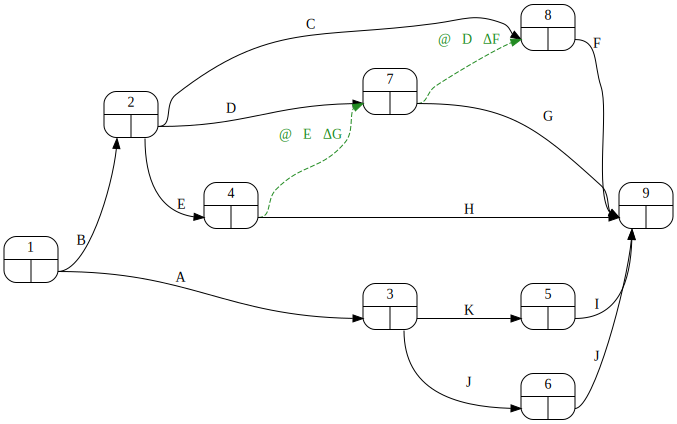

In [7]:
proyecto = prelaciones.create_project()
proyecto.pert(nodesep=0.6)

#### Matriz de Zaderenko

In [8]:
proyecto.zaderenko(durations=datos_proyecto['duracion'])

,1,2,3,4,5,6,7,8,9,early
1,,5.0,5.0,,,,,,,0.0
2,,,,2.0,,,5.0,1.0,,5.0
3,,,,,3.0,1.0,,,,5.0
4,,,,,,,0.0,,2.0,7.0
5,,,,,,,,,4.0,8.0
6,,,,,,,,,2.0,6.0
7,,,,,,,,0.0,2.0,10.0
8,,,,,,,,,1.0,10.0
9,,,,,,,,,,12.0
late,0.0,5.0,5.0,10.0,8.0,10.0,10.0,11.0,12.0,


In [9]:
resultados_pert = proyecto.calculate_pert(durations=datos_proyecto['duracion'])
resultados_pert['nodes']

,early,late
1,0,0
2,5,5
3,5,5
4,7,10
5,8,8
6,6,10
7,10,10
8,10,11
9,12,12


In [10]:
resultados_pert['activities']

,H_total
@∇D⤑ΔF,1
@∇E⤑ΔG,3
A,0
B,0
C,5
D,0
E,3
F,1
G,0
H,3


In [11]:
camino_critico = proyecto.critical_path(datos_proyecto['duracion'])
camino_critico

{'Route_2': ['B', 'D', 'G'], 'Route_7': ['A', 'K', 'I']}

#### Grafo PERT con indicación de tiempos obtenidos de acuerdo a la planificación inicial

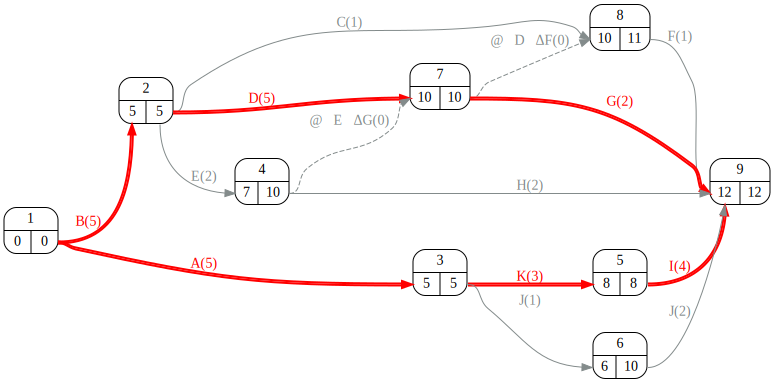

In [12]:
proyecto.pert(durations=datos_proyecto['duracion'])

La duración media del proyecto ya la tenemos calculada:

In [13]:
duracion_media_proyecto = proyecto.duration(datos_proyecto['duracion'])
duracion_media_proyecto

12

Para determinar la desviación típica debemos obtener en cada rama del camino crítico la suma de las varianzas, y quedarnos con la mayor.

In [14]:
desviacion_proyecto = proyecto.standard_deviation(durations=datos_proyecto['duracion'],
                                                   variances=datos_proyecto['varianza'])

Variance path: Route_2 : 3
Variance path: Route_7 : 4
Project duration variance: 4
Project duration standard deviation: 2.0


El proyecto sigue una distribución normal con media 12 y desviación típica 2.

### Apartado 2

> Como no está conforme con la duración del proyecto que resulta, desea reducir la duración del proyecto en 1 mes con el mínimo incremento de coste posible. ¿Qué tareas deben ser reducidas?.

Se aborda la solución de este apartado mediante la récnica de reducción de la duración del proyecto con mínimo coste.

In [15]:
ackoff, best_option, duration, available = proyecto.ackoff(durations=datos_proyecto['duracion'],
                min_durations=datos_proyecto['duracion_tope'],
                costs=datos_proyecto['cur'],
                reduction=1)
ackoff

D shape (12,)
Path matrix shape (8, 12)


Step: 0,	 Best option: ['B', 'I'], 	 Cost: 70.0, 	 Critical paths: ['Route_2', 'Route_7']





,A,B,C,D,E,F,G,H,I,J,K,💤J,0,1
Route_1,,20.0,30.0,,,10.0,,,,,,,7.0,6.0
Route_2,,20.0,,25.0,,,10.0,,,,,,12.0,11.0
Route_3,,20.0,,25.0,,10.0,,,,,,,11.0,10.0
Route_4,,20.0,,,30.0,,,50.0,,,,,9.0,8.0
Route_5,,20.0,,,30.0,,10.0,,,,,,9.0,8.0
Route_6,,20.0,,,30.0,10.0,,,,,,,8.0,7.0
Route_7,60.0,,,,,,,,50.0,,10.0,,12.0,11.0
Route_8,60.0,,,,,,,,,10.0,,,8.0,8.0
0,3.0,3.0,0.0,4.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,,
1,3.0,2.0,0.0,4.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,,


En la rama B-D-G la actividad más barata es la G pero ya está en su duración tope. La siguiente más barata es la B que dispone de 3 periodos de reducción.

Se propone reducir la B y la I.

### Apartado 3.
> Debido al racionamiento de combustible diesel que sufre la isla, durante el proyecto sólo será posible disponer de 250 litros de gasoil cada semana; y debido a la falta de previsión de los responsables del proyecto, que no solicitaron permiso para el almacenamiento de combustible, no es posible guardar el sobrante de una semana para consumirlo la siguiente. Por otro lado las necesidades de consumo de gasoil que usted planifica son las que se muestran en la tabla. ¿Se encuentra bien nivelado el consumo de gasoil?. ¿Se encuentra bien asignado?. Si no es así ¿qué recomienda hacer para asignar correctamente el consumo de combustible?. ¿Qué consecuencias traerá la asignación correcta del combustible en este proyecto en concreto?.

In [16]:
datos_proyecto['litros_por_mes'] = 4 * datos_enunciado['litros']   # Se considera el gasto mensual 4 veces el coste semanal
datos_proyecto[['litros_por_mes']]

,litros_por_mes
actividad,
A,840
B,600
C,200
D,300
E,100
F,300
G,300
H,0
I,400


In [17]:
gantt_recursos = proyecto.gantt(datos_proyecto,
                                'duracion',
                                'litros_por_mes',
                                total='fila',
                                holguras=True)
gantt_recursos

,1,2,3,4,5,6,7,8,9,10,11,12,H_total
A,840,840,840,840,840,,,,,,,,0.000000
B,600,600,600,600,600,,,,,,,,0.000000
C,,,,,,200,,,,,,,5.000000
D,,,,,,300,300,300,300,300,,,0.000000
E,,,,,,100,100,,,,,,3.000000
F,,,,,,,,,,,300,,1.000000
G,,,,,,,,,,,300,300,0.000000
H,,,,,,,,0,0,,,,3.000000
I,,,,,,,,,400,400,400,400,0.000000
J,,,,,,,200,200,,,,,4.000000


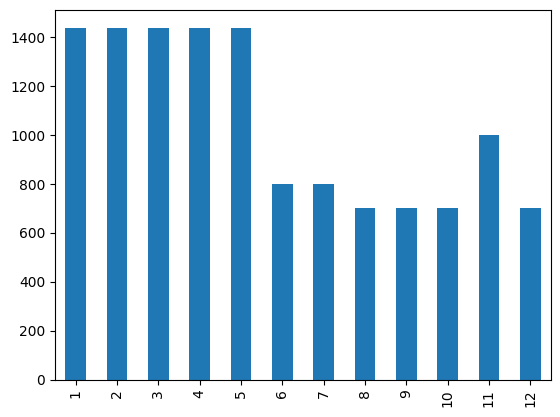

In [18]:
(gantt_recursos.data.loc['Total'].drop('H_total').plot(kind='bar'));

La demanda del recurso no se encuantra nivelada.
Además, con el máximo disponible de 1000 litros por mes el proyecto no es ejecutable en su estado actual y debe aplicarse el algoritmo de asignación.

#### Algoritmo de asignación

Durante los primeros seis periodos no es viable ejecutar A y B. Como ambas son críticas y de misma duración resulta indiferente desplazar una u otra pues en ambos casos esta acción conlleva un retraso del proyecto. Resolvemos el ejercicio desplazando la actividad B.

In [19]:
proyecto_asignacion = proyecto.copy()
duraciones_y_recursos = datos_proyecto[['duracion', 'litros_por_mes']]
duraciones_y_recursos = proyecto_asignacion.desplazar(duraciones_y_recursos, 'duracion', 'litros_por_mes', B = 5 )

Suma de cuadrados: 10528000.0 



,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,H_total
A,840.000000,840.000000,840.000000,840.000000,840.000000,,,,,,,,,,,,,5.000000
B,,,,,,600.000000,600.000000,600.000000,600.000000,600.000000,,,,,,,,0.000000
C,,,,,,,,,,,200.000000,,,,,,,5.000000
D,,,,,,,,,,,300.000000,300.000000,300.000000,300.000000,300.000000,,,0.000000
E,,,,,,,,,,,100.000000,100.000000,,,,,,3.000000
F,,,,,,,,,,,,,,,,300.000000,,1.000000
G,,,,,,,,,,,,,,,,300.000000,300.000000,0.000000
H,,,,,,,,,,,,,0.000000,0.000000,,,,3.000000
I,,,,,,,,,400.000000,400.000000,400.000000,400.000000,,,,,,5.000000
J,,,,,,,200.000000,200.000000,,,,,,,,,,9.000000


La actividad *💤B* representa el desplazamiento de la tarea _B_. La siguiente gráfica representa la demanda de recursos tras este desplazamiento.

Con esta única acción la demanda de recursos del proyecto ya no supera las 1000 unidades que nos ponía de límite en el enunciado. La duración no obstante ha subido a 17 meses y el camino crítico ha cambiado.

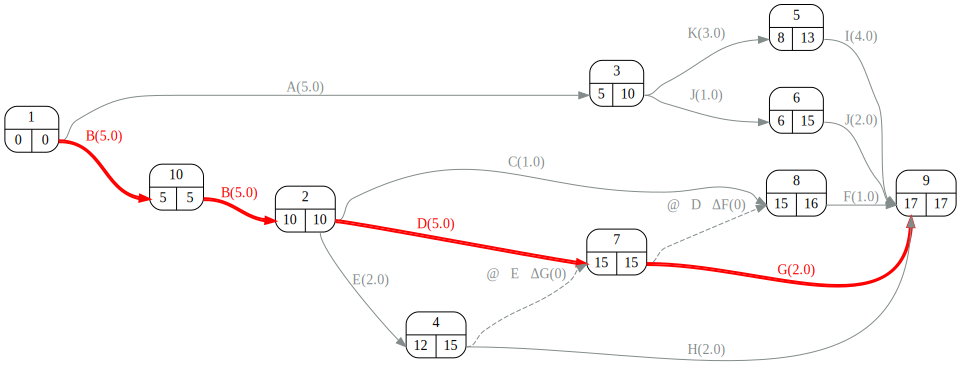

In [20]:
proyecto_asignacion.pert(durations=duraciones_y_recursos['duracion'])

In [21]:
proyecto_asignacion.critical_path(durations=duraciones_y_recursos['duracion'])

{'Route_4': ['💤B', 'B', 'D', 'G']}